<a href="https://colab.research.google.com/github/nhahub/NHA-4-173/blob/main/Evaluation_Metrics_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# T5 (Text-To-Text Transfer Transformer)


T5 (Text-To-Text Transfer Transformer) is a versatile NLP model by Google that treats all tasks as text-to-text problems. It translates input text into output text for tasks like translation, summarization, and question answering. Key features include:

Unified Framework: Handles various tasks with a single model approach.

Pre-training: Uses a large corpus and is fine-tuned on diverse tasks.

Scalable: Available in different sizes for various needs.

Transfer Learning: Applies knowledge from pre-training to improve performance on multiple tasks.

**Applications:**

Translation: Translating text from one language to another.

Summarization: Summarizing long documents or articles into shorter versions.

Question Answering: Generating answers to questions based on provided context.

Text Classification: Classifying text into different categories.

Text Generation: Generating new text based on input prompts.


In [1]:
!pip install transformers datasets tensorflow


In [2]:
!pip install -U transformers accelerate peft evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 5.0.0
    Uninstalling transformers-5.0.0:
      Successfully uninstalled transformers-5.0.0


In [3]:
from transformers import AutoModelForSeq2SeqLM, T5Tokenizer,T5ForConditionalGeneration
import tensorflow as tf
from transformers import Trainer, TrainingArguments
from datasets import load_dataset


In [4]:
import torch

In [5]:
from datasets import load_dataset

# Load the full dataset
dataset = load_dataset('wmt16', 'de-en')

# Limit the dataset size (e.g., 500 examples for training and 100 for validation)
num_train_samples = 500
num_eval_samples = 100

# Take subsets of the dataset
train_subset = dataset['train'].select(range(num_train_samples))
eval_subset = dataset['validation'].select(range(num_eval_samples))

# Update the dataset with the subsets
dataset = {
    'train': train_subset,
    'validation': eval_subset
}


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

de-en/train-00000-of-00003.parquet:   0%|          | 0.00/282M [00:00<?, ?B/s]

de-en/train-00001-of-00003.parquet:   0%|          | 0.00/267M [00:00<?, ?B/s]

de-en/train-00002-of-00003.parquet:   0%|          | 0.00/277M [00:00<?, ?B/s]

de-en/validation-00000-of-00001.parquet:   0%|          | 0.00/343k [00:00<?, ?B/s]

de-en/test-00000-of-00001.parquet:   0%|          | 0.00/475k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4548885 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2169 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2999 [00:00<?, ? examples/s]

In [6]:
dataset['train']['translation'][0]

{'de': 'Wiederaufnahme der Sitzungsperiode', 'en': 'Resumption of the session'}

In [7]:
model_name = "t5-small"  # You can choose a larger model if needed
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/131 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [8]:
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.pad_token_id

In [9]:
import numpy as np

tokenized_lengths = [len(tokenizer.encode(ex['translation']['en'], add_special_tokens=True))
                     for ex in dataset['train']]


mean_len = np.mean(tokenized_lengths)
median_len = np.median(tokenized_lengths)
max_len = np.max(tokenized_lengths)
p95 = np.percentile(tokenized_lengths, 95)
p98 = np.percentile(tokenized_lengths, 98)

print(f"Mean: {mean_len}, Median: {median_len}, Max: {max_len}")
print(f"95th percentile: {p95}, 98th percentile: {p98}")
max_length = int(np.percentile(tokenized_lengths, 95))
print("Suggested max_length based on distribution (95th percentile):", max_length)

Mean: 33.55, Median: 28.0, Max: 127
95th percentile: 73.04999999999995, 98th percentile: 94.01999999999998
Suggested max_length based on distribution (95th percentile): 73


In [12]:
def preprocess_function(examples):
    prompt = "translate English to German: "
    inputs = [prompt + ex['en'] for ex in examples['translation']]
    targets = [ex['de'] for ex in examples['translation']]

    model_inputs = tokenizer(
        inputs,
        max_length=max_length,
        truncation=True,
        padding='max_length',
        add_special_tokens=True
    )

    # Tokenize targets
    labels = tokenizer(
        targets,
        max_length=max_length,
        truncation=True,
        padding='max_length',
        add_special_tokens=True
    )
    labels_ids = labels["input_ids"]
    labels_ids = [
        [(token if token != tokenizer.pad_token_id else -100) for token in label]
        for label in labels_ids
    ]
    # Add labels to model_inputs
    model_inputs['labels'] = labels['input_ids']
    return model_inputs

tokenized_datasets = {
    'train': dataset['train'].map(preprocess_function, batched=True),
    'validation': dataset['validation'].map(preprocess_function, batched=True)
}

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [13]:
from peft import LoraConfig, get_peft_model, TaskType

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    target_modules=["q","v"],   # T5 layers
    task_type=TaskType.SEQ_2_SEQ_LM
)

model = get_peft_model(model, lora_config)

model.print_trainable_parameters()

trainable params: 294,912 || all params: 60,801,536 || trainable%: 0.4850


In [14]:
example = {'translation':
           {'de': 'Wiederaufnahme der Sitzungsperiode',
            'en': 'Resumption of the session'}}

In [16]:
tokenized_datasets['train'][12]

{'translation': {'de': 'Wenn das Haus damit einverstanden ist, werde ich dem Vorschlag von Herrn Evans folgen.',
  'en': 'If the House agrees, I shall do as Mr Evans has suggested.'},
 'input_ids': [13959,
  1566,
  12,
  2968,
  10,
  156,
  8,
  1384,
  2065,
  7,
  6,
  27,
  1522,
  103,
  38,
  1363,
  18305,
  65,
  5259,
  5,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'labels': [274

In [17]:
from transformers import TrainingArguments, IntervalStrategy

# Define training arguments
training_args = TrainingArguments(
    per_device_train_batch_size=32,  # Training batch size
    per_device_eval_batch_size=100,  # Evaluation batch size
    num_train_epochs=4,  # Number of epochs
    logging_dir='./logs',  # Directory for logs
    logging_steps=10,  # Log every 10 steps
    # evaluation_strategy=IntervalStrategy.STEPS,  # Temporarily removed due to TypeError
    # save_strategy=IntervalStrategy.NO,  # Temporarily removed due to TypeError
    output_dir="./results"  # Directory for model and checkpoints
)

`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


In [18]:
# Create Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation']
)

In [19]:
# Train the model
trainer.train()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Step,Training Loss
10,2.362173
20,2.237853
30,2.202402
40,2.152779
50,2.042356
60,2.089397


TrainOutput(global_step=64, training_loss=2.1746741831302643, metrics={'train_runtime': 951.6481, 'train_samples_per_second': 2.102, 'train_steps_per_second': 0.067, 'total_flos': 38851903488000.0, 'train_loss': 2.1746741831302643, 'epoch': 4.0})

In [20]:
import math
# Evaluate the model after training
eval_results = trainer.evaluate()


loss = eval_results["eval_loss"]
perplexity = math.exp(loss)

print("Loss:", loss)
print("Perplexity:", perplexity)

# Print evaluation results
print("Evaluation Results:")
print(eval_results)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Loss: 1.5350459814071655
Perplexity: 4.64153894953957
Evaluation Results:
{'eval_loss': 1.5350459814071655, 'eval_runtime': 18.8371, 'eval_samples_per_second': 5.309, 'eval_steps_per_second': 0.053, 'epoch': 4.0}


In [21]:
# Save the model
model_path = "./results"
model.save_pretrained(model_path)

# Save the tokenizer
tokenizer.save_pretrained(model_path)

('./results/tokenizer_config.json', './results/tokenizer.json')

In [22]:
import torch

def generate_predictions(model, dataset):
    model.eval()
    preds, refs = [], []

    for item in dataset:
        text = "translate English to German: " + item["translation"]["en"]

        inputs = tokenizer(text, return_tensors="pt")

        with torch.no_grad():
            output = model.generate(**inputs, max_length=128)

        pred = tokenizer.decode(output[0], skip_special_tokens=True)
        ref = item["translation"]["de"]

        preds.append(pred)
        refs.append(ref)

    return preds, refs


preds, refs = generate_predictions(model, dataset["validation"])


In [23]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import evaluate


device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)


prompt = "translate English to German: "
val_examples = dataset['validation'].select(range(50))
inputs = [prompt + ex['translation']['en'] for ex in val_examples]
refs = [ex['translation']['de'] for ex in val_examples]

tokenized_inputs = tokenizer(
    inputs,
    max_length=128,
    padding="max_length",
    truncation=True,
    return_tensors="pt"
)
input_ids = tokenized_inputs['input_ids'].to(device)
attention_mask = tokenized_inputs['attention_mask'].to(device)


with torch.no_grad():
    outputs = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_length=128
    )

preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)


bleu = evaluate.load("bleu")
bleu_score = bleu.compute(
    predictions=preds,
    references=[[r] for r in refs]
)

print("BLEU score:", bleu_score["bleu"])


BLEU score: 0.3224927577856194


In [26]:
!pip install rouge_score


  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=2b2a02e462ed05d2f3df9647ff0193779d5b3f1c93c52107a7e427cbde92b014
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score


In [27]:
import evaluate
rouge = evaluate.load("rouge")


In [28]:
import evaluate

rouge = evaluate.load("rouge")

rouge_score = rouge.compute(
    predictions=preds,
    references=refs
)

print(rouge_score)


{'rouge1': np.float64(0.611864630256601), 'rouge2': np.float64(0.3986912458771136), 'rougeL': np.float64(0.5622746018058955), 'rougeLsum': np.float64(0.5616301905887193)}


# ⏳ Task:

1. Add PEFT technique to the training.

2. Evaluation on validation dataset 50 or all 100 samples:
   * BLEU Score
   * ROUGE-Score
   * Perplexity  

# **BLEU Score (Bilingual Evaluation Understudy)**

The **BLEU score** is an automatic evaluation metric commonly used to assess the quality of machine-generated text (especially machine translation) by comparing it to one or more reference texts.

---

## **Key Components**

### **1. N-gram Precision (Clipped Precision)**
BLEU computes precision over multiple n-gram sizes (e.g., unigrams, bigrams, trigrams, 4-grams).

- **Precision** is defined as the fraction of *machine-generated n-grams* that also appear in the reference translations.
- To avoid artificially high scores from repeated words, BLEU uses **clipped counts**, meaning an n-gram cannot be counted more times than it appears in the reference.

$P_n = \frac{\sum_{\text{ngram}} \min(\text{count}_{\text{candidate}}, \text{count}_{\text{reference}})}{\sum_{\text{ngram}} \text{count}_{\text{candidate}}}$

---

### **2. Brevity Penalty (BP)**
BLEU penalizes translations that are **too short**, as short outputs may achieve high precision without conveying full meaning.

Let:
- $c$ = length of the candidate (generated) translation  
- $r$ = length of the closest reference translation  

$BP =
\begin{cases}
1, & \text{if } c > r \\
\exp\left(1 - \frac{r}{c}\right), & \text{if } c \le r
\end{cases}$

This ensures that excessively short translations receive a lower BLEU score.

---

### **3. Geometric Mean of N-gram Precisions**
BLEU combines the precision scores across different n-gram orders using a **geometric mean**, not an arithmetic mean.

$\text{BLEU} = BP \times \exp\left( \sum_{n=1}^{N} w_n \log P_n \right)$

- $P_n$: precision for n-grams of size $n$  
- $w_n$: weights (typically uniform, e.g., $w_n = \frac{1}{N}$)  

This formulation balances performance across short- and long-range dependencies.

---

### **4. Score Range and Interpretation**
- BLEU scores theoretically range from **0 to 1**, where:
  - **1** indicates a perfect match with the reference translations.
  - **0** indicates no overlap.
- In practice, BLEU is often reported on a **0–100 scale** (simply BLEU × 100).
- Real-world BLEU scores are usually much lower than 1, and higher values indicate better translation quality.

---

### **Summary**
BLEU measures translation quality using:
- **Clipped n-gram precision**
- **A brevity penalty** to prevent overly short outputs
- **A geometric mean** to balance different n-gram levels

While efficient and widely used, BLEU focuses on surface-level overlap and may not fully capture semantic quality.



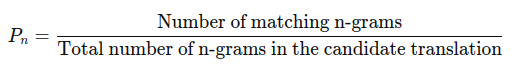


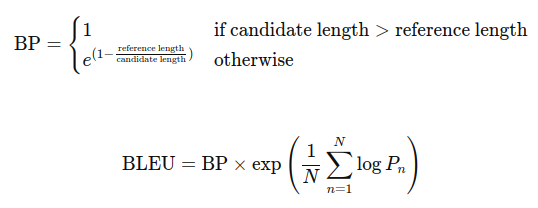



**where:**
* BP is the brevity penalty.
​
* $P_{n}$  is the precision for n-grams of size

* N is the maximum n-gram size (usually 4).

## **Illustrative Example (Step-by-Step BLEU Computation)**

Suppose we have the following candidate and reference translations:

**Candidate Translation:**  
`"the cat is on the mat"`

**Reference Translation:**  
`"the cat is sitting on the mat"`

We compute BLEU using **unigrams and bigrams** ($n = 1, 2$) with **uniform weights**.

---

## **1. Unigram Precision ($n = 1$)**

**Candidate Unigrams:**  
$\{\text{the}, \text{cat}, \text{is}, \text{on}, \text{the}, \text{mat}\}$

**Reference Unigrams:**  
$\{\text{the}, \text{cat}, \text{is}, \text{sitting}, \text{on}, \text{the}, \text{mat}\}$

**Matching Unigrams (clipped):**  
$\{\text{the}, \text{cat}, \text{is}, \text{on}, \text{mat}\}$

- Number of matching unigrams = $6$  
- Total unigrams in candidate = $6$

$P_1 = \frac{6}{6} \approx 1.0$

---

## **2. Bigram Precision ($n = 2$)**

**Candidate Bigrams:**  
$\{(\text{the, cat}), (\text{cat, is}), (\text{is, on}), (\text{on, the}), (\text{the, mat})\}$

**Reference Bigrams:**  
$\{(\text{the, cat}), (\text{cat, is}), (\text{is, sitting}), (\text{sitting, on}), (\text{on, the}), (\text{the, mat})\}$

**Matching Bigrams:**  
$\{(\text{the, cat}), (\text{cat, is}), (\text{on, the}), (\text{the, mat})\}$

- Number of matching bigrams = $4$  
- Total bigrams in candidate = $5$

$P_2 = \frac{4}{5} = 0.8$

---

## **3. Brevity Penalty (BP)**

- Candidate length $c = 6$  
- Reference length $r = 7$  

Since $c < r$, we apply the brevity penalty:

$BP = \exp\left(1 - \frac{r}{c}\right)
= \exp\left(1 - \frac{7}{6}\right)
= \exp\left(-\frac{1}{6}\right)
\approx 0.846$

---

## **4. Final BLEU Score (for $n = 1, 2$)**

Using uniform weights:  
$w_1 = w_2 = \frac{1}{2}$

$\text{BLEU}
= BP \times \exp\left( \frac{1}{2} \log P_1 + \frac{1}{2} \log P_2 \right)$

Substituting values:

$\text{BLEU}
= 0.846 \times \exp\left( \frac{1}{2} \log(0.833) + \frac{1}{2} \log(0.8) \right)$

$\text{BLEU}
= 0.846 \times \exp(-0.198)
\approx 0.846 \times 0.820
\approx 0.694$

---

## **Final Result**

$\boxed{\text{BLEU} \approx 0.69 \quad \text{(or } 69 \text{ on a 0–100 scale)}}$

This example shows how **n-gram precision**, **geometric averaging**, and the **brevity penalty** combine to produce the final BLEU score.


In [ ]:
pip install nltk

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

reference = [['the', 'cat', 'is', 'on', 'the', 'mat']]
candidate = ['the', 'cat', 'is', 'on', 'mat']

score = sentence_bleu(reference, candidate,weights=(0.5,0.5,0,0))
print("BLEU score:", score)

# **ROUGE (Recall-Oriented Understudy for Gisting Evaluation)**

**ROUGE** is a set of metrics commonly used to evaluate **summaries and generated text** by measuring their overlap with one or more reference texts. Unlike BLEU, ROUGE is primarily **recall-oriented**, making it well suited for summarization tasks.

---

## **ROUGE Score Types**

- **ROUGE-N:** Measures n-gram overlap (e.g., unigrams, bigrams) between the generated text and the reference text.
- **ROUGE-L:** Measures the **Longest Common Subsequence (LCS)** between generated and reference texts.
- **ROUGE-W:** A weighted variant of ROUGE-L that emphasizes longer consecutive matches.
- **ROUGE-S:** Measures overlap of **skip-bigrams** (bigrams allowing gaps).

---

## **ROUGE-N Formulation**

Let $N$ be the n-gram size.

### **1. Recall**
Recall measures how much of the reference text is covered by the generated text.

$$
\text{Recall}_N =
\frac{\text{Number of overlapping n-grams}}
{\text{Total number of n-grams in the reference}}
$$

---

### **2. Precision**
Precision measures how much of the generated text is relevant.

$$
\text{Precision}_N =
\frac{\text{Number of overlapping n-grams}}
{\text{Total number of n-grams in the generated text}}
$$

---

### **3. F-score**
The F-score balances recall and precision using their harmonic mean.

$$
F_N =
\frac{2 \times \text{Recall}_N \times \text{Precision}_N}
{\text{Recall}_N + \text{Precision}_N}
$$

---

## **Illustrative Example**

**Generated Summary:**  
`"the cat is on the mat"`

**Reference Summary:**  
`"the cat is sitting on the mat"`

---

## **Unigram Calculation ($n = 1$)**

**Generated Unigrams:**  
$\{\text{the}, \text{cat}, \text{is}, \text{on}, \text{the}, \text{mat}\}$

**Reference Unigrams:**  
$\{\text{the}, \text{cat}, \text{is}, \text{sitting}, \text{on}, \text{the}, \text{mat}\}$

**Overlapping Unigrams:**  
$\{\text{the}, \text{cat}, \text{is}, \text{on}, \text{mat}, \text{the}\}$

- Number of overlapping unigrams = $6$  
- Total unigrams in reference = $7$  
- Total unigrams in generated text = $6$

---

### **ROUGE-1 Recall**
$$
\text{Recall}_1 = \frac{6}{7} \approx 0.867
$$

### **ROUGE-1 Precision**
$$
\text{Precision}_1 = \frac{6}{6} \approx 1.0
$$

### **ROUGE-1 F-score**
$$
F_1 =
\frac{2 \times 0.867 \times 1.0}{0.867 + 1}
\approx 0.929
$$

---

## **Summary**
- ROUGE emphasizes **coverage of reference content**, making it ideal for summarization.
- **ROUGE-N** focuses on exact n-gram overlap.
- **F-score** provides a balanced view when both recall and precision matter.


In [ ]:
!pip install rouge-score


In [ ]:
from rouge_score import rouge_scorer

reference = "the cat is sitting on the mat"
candidate = "the cat is on the mat"

# Initialize ROUGE scorer with n-gram ROUGE
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rouge3','rougeL'], use_stemmer=True)
scores = scorer.score(reference, candidate)

print("ROUGE-1 F1:", round(scores['rouge1'].fmeasure, 3))
print("ROUGE-2 F1:", round(scores['rouge2'].fmeasure, 3))
print("ROUGE-3 F1:", round(scores['rouge3'].fmeasure, 3))
print("ROUGE-3 F1:", round(scores['rougeL'].fmeasure, 3))


In [ ]:
# Reference and candidate sentences
reference = "the cat is sitting on the mat"
candidate = "the cat is on the mat"

# --- ROUGE-S (skip-bigram) manually ---

from itertools import combinations

def get_skip_bigrams(tokens):
    """
    Returns all skip-bigrams (pairs of tokens in order, not necessarily adjacent)
    """
    return list(combinations(tokens, 2))

# Tokenize sentences
ref_tokens = reference.split()
cand_tokens = candidate.split()

# Get skip-bigrams
ref_skip_bigrams = set(get_skip_bigrams(ref_tokens))
cand_skip_bigrams = set(get_skip_bigrams(cand_tokens))

# Compute overlap
matching_bigrams = ref_skip_bigrams & cand_skip_bigrams

# ROUGE-S precision, recall, F1
precision = len(matching_bigrams) / len(cand_skip_bigrams)
recall = len(matching_bigrams) / len(ref_skip_bigrams)
f1 = 2 * precision * recall / (precision + recall)

print("\nROUGE-S (skip-bigram) results:")
print("Matching skip-bigrams:", len(matching_bigrams))
print("Precision:", round(precision, 3))
print("Recall:", round(recall, 3))
print("F1 score:", round(f1, 3))


# **Perplexity**

**Perplexity** is an evaluation metric commonly used to measure how well a language model predicts a sequence of text. It is widely used for **language modeling**, rather than direct comparison with reference texts like BLEU or ROUGE.

Intuitively, perplexity measures how *surprised* a model is by the true next tokens.  
- **Lower perplexity** → better language model  
- **Higher perplexity** → worse predictions  

---

## **Definition**

Given a sequence of tokens $w_1, w_2, \dots, w_N$, perplexity is defined as the exponential of the **average negative log-likelihood** of the sequence under the model.

$$
\text{Perplexity} = \exp\left(
-\frac{1}{N} \sum_{i=1}^{N} \log P(w_i \mid w_1, \dots, w_{i-1})
\right)
$$

Where:
- $N$ is the number of tokens
- $P(w_i \mid w_1, \dots, w_{i-1})$ is the probability assigned by the model to the correct next token

---

## **Interpretation**

- A perplexity of **$k$** means the model is, on average, as uncertain as choosing among **$k$ equally likely tokens** at each step.
- Perfect prediction would give a perplexity of **1**.
- Random guessing over a vocabulary of size $V$ yields perplexity close to $V$.

---

## **Example**

Suppose a language model assigns the following probabilities to the correct next tokens in a sequence of 3 tokens:

- $P(w_1) = 0.5$
- $P(w_2 \mid w_1) = 0.25$
- $P(w_3 \mid w_1, w_2) = 0.25$

Compute the perplexity:

$$
\text{Perplexity}
= \exp\left(
-\frac{1}{3} (\log 0.5 + \log 0.25 + \log 0.25)
\right)
$$

$$
= \exp(1.155) \approx 3.17
$$

This means the model behaves as if it were choosing among about **3 equally likely options** at each step.

---

## **Advantages and Limitations**

### ✅ **Advantages**
- Directly measures how well a model predicts data
- Standard metric for training and comparing language models
- Sensitive to probability calibration

### ❌ **Limitations**
- Not directly interpretable as output quality
- Cannot compare models with different tokenization schemes
- Does not measure semantic correctness or fluency from a human perspective

---

## **Summary**
Perplexity evaluates the **predictive quality** of a language model by measuring uncertainty over the next token. While essential for training and diagnostics, it should be complemented with human-centered or task-specific metrics for real-world evaluation.


In [ ]:
import torch
import math

# Fake negative log-likelihoods per token (lower = better)
log_likelihoods = {
    "Good but shorter": [-0.6, -0.7, -0.5, -0.6], #candidate 1 log probabilities
    "Paraphrase": [-0.9, -0.8, -0.9, -0.85], #candidate 2 log probabilities
    "Poor quality": [-1.5, -1.6, -1.7, -1.8] #candidate 3 log probabilities
}

print("Perplexity (Toy Example):")
for name, values in log_likelihoods.items():
    avg_nll = -sum(values) / len(values)
    perplexity = math.exp(avg_nll)
    print(f"{name}: {perplexity:.2f}")